In [1]:
# !/usr/local/lib/python2.7 python 
# -*- coding=utf-8 -*-  

# bridging the python 2 and python 3 gap
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function


import os # saving files
import numpy as np # for matrix math
import matplotlib.pyplot as plt # plot and visualizing data 
import tensorflow as tf
from data_utils import shuffle, iter_data # analyzing data 
from tqdm import tqdm # progress bar

import preprocessing 
import post_processing
import networks as net



For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.



# Preprocessing Step

## Coverting a POSCAR files to a 4-D tensor 

Here is an exemple of feeding a POSCAR features in a multidimensional matrix




## Data Representation through POSCAR file 
### 4 geometric features for each POSCAR input
We add an empty placeholder to prepare our data sets for complexity augmentation 






In [2]:
# Our datasets are in matlab format
# POSCAR files are converted to .mat file format (multidimensional tensor)
# Please check "POSCAR2mat.m" file to convert your POSCAR files into CrystalGAN format


# Read input datasets
NiH = preprocessing.read_data('data/NiH_dataset.mat')
PdH = preprocessing.read_data('data/PdH_dataset.mat')

In [3]:
# shape of 4D datasets

print(np.shape(NiH))
print(np.shape(PdH))


(35, 4)
(35, 4)


In [4]:
max_PdH = preprocessing.compute_max(PdH)
max_NiH = preprocessing.compute_max(NiH)
max_len = max(max_PdH,max_NiH)


In [5]:
# datasets padding 
Ni_H = preprocessing.data_padding(NiH,max_len)
Pd_H = preprocessing.data_padding(PdH,max_len)

In [6]:
#check if the data with fixed 4D dimension
print(np.shape(Ni_H))
print(np.shape(Pd_H))

(35, 4, 18, 3)
(35, 4, 18, 3)


In [7]:
print(max_len)

18


# Hyperparameters

In [8]:

n_epoch =100
batch_size  = 35
input_dim = 3
latent_dim = 3
eps_dim = 3

# discriminator
n_layer_disc = 5
n_hidden_disc = 100

# generator
n_layer_gen = 5
n_hidden_gen= 100

# inference (#it's a generator as well)
n_layer_inf = 5
n_hidden_inf= 100


In [9]:
## create directory for results
result_dir = 'STEP1+STEP2_CrsytalGAN/'
directory = result_dir
if not os.path.exists(directory):
    os.makedirs(directory)

# true samples of AH and ZH
# Pd_H and Ni_H in this case 
AH_dataset = Pd_H
BH_dataset = Ni_H

print(np.shape(AH_dataset))
print(np.shape(BH_dataset))

(35, 4, 18, 3)
(35, 4, 18, 3)


# CrystalGAN Architecture
###  3 main steps:
Here we present two steps : STEP 1 and STEP 2

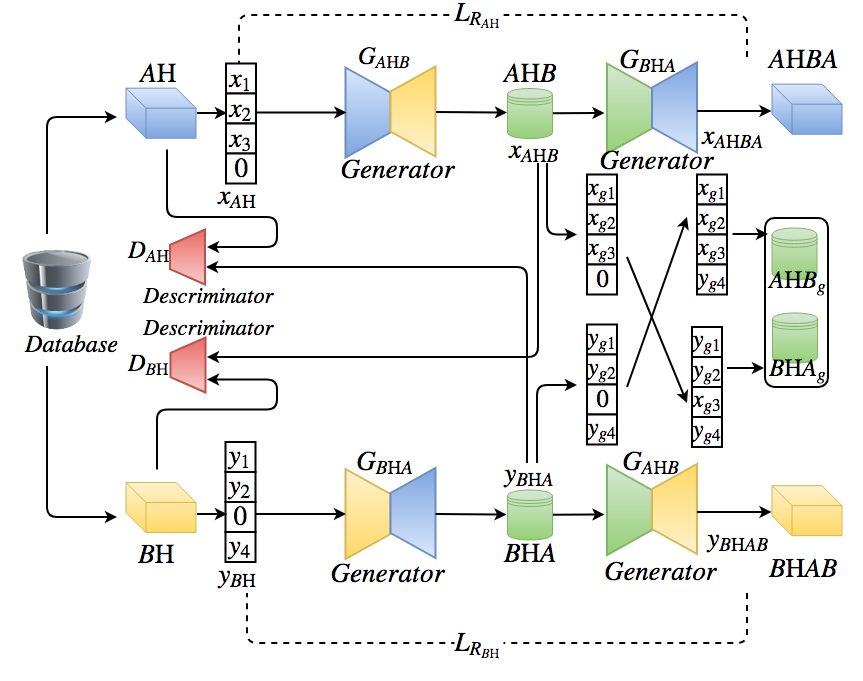

In [10]:
# data 1 input
x_AH = tf.placeholder(tf.float32, shape=([35, 4, 18, 3]))
# data 2 input
y_BH = tf.placeholder(tf.float32, shape=([35, 4, 18, 3]))

In [11]:
### Construct model and training ops
tf.reset_default_graph()
#Create a new graph which compute the targets from the replaced Tensors.
graph_replace = tf.contrib.graph_editor.graph_replace
### Create placeholders to feed our datasets
# data 1 input
x_AH = tf.placeholder(tf.float32, shape=([35, 4, 18, 3]))
# data 2 input
y_BH = tf.placeholder(tf.float32, shape=([35, 4, 18, 3]))

## decoder and encoder model and training ops 

# 2 generators - encoders 

AHB = net.Generator_AHB(y_BH, input_dim , n_layer_gen, n_hidden_gen, eps_dim, None) 
BHA = net.Generator_BHA(x_AH, latent_dim, n_layer_inf, n_hidden_inf, eps_dim, None) 


# 2 discriminators
decoder_logit_x = net.Discriminator_BH(AHB, n_layers=n_layer_disc, n_hidden=n_hidden_disc)
encoder_logit_x = graph_replace(decoder_logit_x, {AHB: x_AH}) 
decoder_logit_y = net.Discriminator_AH(BHA, n_layers=n_layer_disc, n_hidden=n_hidden_disc)
encoder_logit_y = graph_replace(decoder_logit_y, {BHA: y_BH}) 

# Compute softplus 
# to calculate loss

encoder_sigmoid_x = tf.nn.softplus(encoder_logit_x)
decoder_sigmoid_x = tf.nn.softplus(decoder_logit_x)
encoder_sigmoid_y = tf.nn.softplus(encoder_logit_y)
decoder_sigmoid_y = tf.nn.softplus(decoder_logit_y)


## Loss functions

# loss for both discriminators
decoder_loss = decoder_sigmoid_x + decoder_sigmoid_y
encoder_loss = encoder_sigmoid_x + encoder_sigmoid_y

# combined loss for discriminators

disc_loss = tf.reduce_mean(encoder_loss) - tf.reduce_mean(decoder_loss)

# 2 more generators - decoders

rec_AH = net.Generator_BHA(AHB, latent_dim, n_layer_inf, n_hidden_inf, eps_dim, True)
rec_BH = net.Generator_AHB(BHA, input_dim , n_layer_gen, n_hidden_gen,  eps_dim, True)


# Reconstruction loss 
# L_R_AH
cost_AH = tf.reduce_mean(tf.pow(rec_AH - y_BH, 2))

#L_R_BH
cost_BH = tf.reduce_mean(tf.pow(rec_BH - x_AH, 2))

adv_loss = tf.reduce_mean(decoder_loss) # + tf.reduce_mean( encoder_loss )
gen_loss = 1*adv_loss + 1.*cost_BH  + 1.*cost_AH

vars_x = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES,   "inference")
vars_y = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES,   "generative")
dvars_x = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, "discriminator_x")
dvars_y = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, "discriminator_y")
opt = tf.train.AdamOptimizer(1e-4, beta1=0.5)
train_gen_op =  opt.minimize(gen_loss, var_list=vars_x + vars_y)
train_disc_op = opt.minimize(disc_loss, var_list=dvars_x + dvars_y)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use `tf.GraphKeys.GLOBAL_VARIABLES` instead.


In [12]:
##############################################################################################
# TRAINING
##############################################################################################
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())


FG = []
FD = []


for epoch in tqdm(range(n_epoch), total=n_epoch):
    AH_dataset, BH_dataset= shuffle(AH_dataset, BH_dataset)

    for x, y in iter_data(AH_dataset, BH_dataset, size=batch_size):

        for _ in range(1):
            f_d, _ = sess.run([disc_loss, train_disc_op], feed_dict={x_AH: x, y_BH:y})
        for _ in range(5):
            f_g, _ = sess.run([[adv_loss, cost_BH, cost_AH], train_gen_op], feed_dict={x_AH: x, y_BH:y})

        FG.append(f_g)
        FD.append(f_d)
    writer = tf.summary.FileWriter('./graphs',sess.graph)
    writer.close()   


100%|██████████| 100/100 [01:07<00:00,  1.52it/s]


In [13]:
## get results 
# generated data 

n_viz = 1
BHA_gen = np.array([]); recon_AH = np.array([]); AHB_gen = np.array([]); recon_BH = np.array([]);


for _ in range(n_viz):
    for x, y in iter_data(AH_dataset, BH_dataset, size=batch_size):
        
        # generated data
        temp_BHA_gen = sess.run(BHA, feed_dict={x_AH: x, y_BH:y})
        BHA_gen = np.vstack([BHA_gen, temp_BHA_gen]) if BHA_gen.size else temp_BHA_gen
        
        # reconstructed data
        temp_recon_AH = sess.run(rec_AH, feed_dict={x_AH: x, y_BH:y})
        recon_AH = np.vstack([recon_AH, temp_recon_AH]) if recon_AH.size else temp_recon_AH
        
        # generated data
        temp_AHB_gen = sess.run(AHB, feed_dict={x_AH: x, y_BH:y})
        AHB_gen = np.vstack([AHB_gen, temp_AHB_gen]) if AHB_gen.size else temp_AHB_gen
        
        # reconstructed data
        temp_recon_BH = sess.run(rec_BH, feed_dict={x_AH: x, y_BH:y})
        recon_BH = np.vstack([recon_BH, temp_recon_BH]) if recon_BH.size else temp_recon_BH

### Note: 

BHA_gen and AHB_gen: the generated data

recon_BH and recon_AH: the reconstructed data    

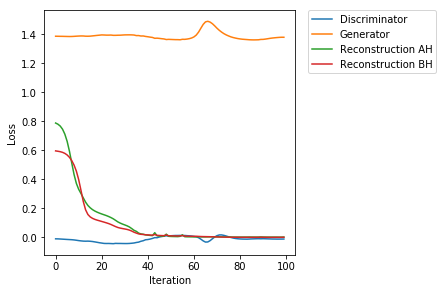

In [14]:
##--------------------------------------------
## ---------- learning curves ----------------
##--------------------------------------------
# plot loss per iteration 
# for generators and discriminators
fig_curve, ax = plt.subplots(nrows=1, ncols=1, figsize=(4.5, 4.5))
ax.plot(FD, label="Discriminator")
ax.plot(np.array(FG)[:,0], label="Generator")
ax.plot(np.array(FG)[:,1], label="Reconstruction AH")
ax.plot(np.array(FG)[:,2], label="Reconstruction BH")
#ax.set_yscale('log')
plt.ylabel('Loss')
plt.xlabel('Iteration')
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
ax.axis('on')
plt.show()


In [15]:
# convert numpy arrays to lists
# to facilate post processing data
BHA_gen = BHA_gen.tolist()
AHB_gen = AHB_gen.tolist()
recon_AH = recon_AH.tolist()
recon_BH = recon_BH.tolist()

In [16]:
type(BHA_gen)

list

# STEP 2 of CrystalGAN: Feature Transfer

In [17]:
AHB_g= []; BHA_g=[]
for i in range(35):
    AHB_g.append([AHB_gen[i][0], AHB_gen[i][1], BHA_gen[i][2], AHB_gen[i][3]])
    BHA_g.append([BHA_gen[i][0], BHA_gen[i][1], AHB_gen[i][2], BHA_gen[i][3]])

# Save data which will be used as input in Step 3 of CrystalGAN

This data is obtained after STEP1 + STEP2 

It will be used to train  an other cross-domain GAN with constraints, in order to explore ternary chemical compounds by adding some real-valued (geometric) conditions.

In [18]:
np.save(directory+'AHB_g.npy', AHB_g)
np.save(directory+'BHA_g.npy', BHA_g)

# Post Processing Data:

==> Removing the padding zeros in the generated data.

This step is required to print POSCAR files, in order to explore the new generated data.

Note that here we only generate pseudo-binary chemical compounds.

We need to train an other GAN after STEP 2 (Feature Transfer) in order to generate ternary compounds


In [19]:
# Postprocessing for the generated and the reconstructed data
data_gen1 = post_processing.clean_data(AHB_gen)
data_gen2 = post_processing.clean_data(BHA_gen)
data_rec1 = post_processing.clean_data(recon_AH)
data_rec2 = post_processing.clean_data(recon_BH)

# Exploring pseudo-binary compounds
 
# STEP 1

In [20]:
### Save data as POSCAR files

## Create folders 
out1 = directory+'M1H/'
if not os.path.exists(out1):
    os.makedirs(out1)

out2 = directory+'M2H/'
if not os.path.exists(out2):
        os.makedirs(out2)


### Save POSCAR files 

In [21]:
post_processing.write_POSCAR(out1,data_gen1)
post_processing.write_POSCAR(out2,data_gen2)

# Exploring ternary compounds without STEP 3 of CrystalGAN
# STEP 1 + STEP 2

In [22]:
### Save data as POSCAR files

## create folders for results
out3 = directory+'AHB_g_/'
if not os.path.exists(out3):
    os.makedirs(out3)

out4 = directory+'BHA_g_/'
if not os.path.exists(out4):
        os.makedirs(out4)

### Clean data

In [23]:
# Removing useless informations in the generated data
# Removing padded zeros
# in order to convert data to POSCAR files
PdHNi = post_processing.clean_data(AHB_g)
NiHPd = post_processing.clean_data(BHA_g)

### Save POSCAR files

In [24]:
post_processing.write_POSCAR(out3,PdHNi)
post_processing.write_POSCAR(out4,NiHPd)